In [1]:
import sys
import os

# Adjust the path as needed to reach your project root from the notebook's location
project_root = os.path.abspath(os.path.join(os.getcwd(), '..', '..'))
if project_root not in sys.path:
    sys.path.insert(0, project_root)

project_root

'/Users/peterfalterbaum/Documents/Nova/thesis local/implementation/public_implementation'

In [2]:
from config import PROJECT_ROOT
from pathlib import Path

In [ ]:
import os
import json
import pandas as pd
from pathlib import Path

# Get the decomposition file path
decomposition_path = str(PROJECT_ROOT) + "/data/results/decompositions/CP/final/peak hours normalized/utrecht/odt_no_same_od_no_rare_od_fixed_thresh_normalizedPeaks/odt_utrecht_hourly_weekday/run_20250610_001409/rank_5/odt_processed_utrecht_hourly_weekday_factors.npz"

# Extract the parent directory (rank_5 folder) and go up to the run directory
run_dir = Path(decomposition_path).parent.parent

# Read the run_summary.json file to get the tensor path
run_summary_path = run_dir / "run_summary.json"
if not run_summary_path.exists():
    raise FileNotFoundError(f"Run summary file not found: {run_summary_path}")

with open(run_summary_path, 'r') as f:
    run_summary = json.load(f)

# Extract the tensor file path from the run summary
tensor_file_path = run_summary["tensor_info"]["file"]
tensor_dir = Path(tensor_file_path).parent

# Get the decomposition filename to extract granularity
decomposition_filename = Path(decomposition_path).name
# Extract granularity from filename (e.g., "weekday" from "odt_processed_utrecht_hourly_weekday_factors.npz")
granularity = decomposition_filename.split('_')[-2]  # Gets "weekday"

# Construct the metadata file path using the known format in the tensor directory
metadata_filename = f"odt_processed_utrecht_hourly_{granularity}_metadata.json"
metadata_path = tensor_dir / metadata_filename

# Check if the metadata file exists
if not metadata_path.exists():
    raise FileNotFoundError(f"Metadata file not found: {metadata_path}")

# Read the metadata file to get the source file path
with open(metadata_path, 'r') as f:
    metadata = json.load(f)

# Extract the source file path from metadata
source_file_path = metadata["source_file"]

# Load the original CSV data
# full_original_data = pd.read_csv(source_file_path)
full_original_data = pd.read_csv(
    str(PROJECT_ROOT) + "/data/processed/purpose_person_odt_no_same_od_no_rare_od.csv")

In [4]:
# Convert all columns starting with "pc4_" to string type
pc4_columns = [
    col for col in full_original_data.columns if col.startswith('pc4_')]
for col in pc4_columns:
    full_original_data[col] = full_original_data[col].astype(str)

full_original_data

,pc4_arrival,pc4_departure,timestamp_departure,timestamp_arrival,mode_of_transport,destination/purpose,motive,class_division_motif,age_op,postal_code_residential_address
0,1746,1742,2022-11-28 08:45:00,2022-11-28 08:55:00,1,11,10,7,76,1742
1,6511,6542,2022-10-04 13:30:00,2022-10-04 13:40:00,5,2,1,1,83,6542
2,6542,6511,2022-10-04 18:00:00,2022-10-04 18:10:00,5,1,8,6,83,6542
3,6511,6542,2022-10-04 19:00:00,2022-10-04 19:10:00,5,12,11,7,83,6542
4,6542,6511,2022-10-04 21:00:00,2022-10-04 21:08:00,5,1,11,7,83,6542
...,...,...,...,...,...,...,...,...,...,...
60082,3401,3403,2022-02-05 08:00:00,2022-02-05 08:06:00,6,8,7,4,63,3403
60083,3403,3401,2022-02-05 08:26:00,2022-02-05 08:33:00,6,1,7,4,63,3403
60084,3403,3401,2022-02-05 14:20:00,2022-02-05 14:25:00,5,1,7,4,63,3403
60085,1509,1506,2022-12-08 18:20:00,2022-12-08 18:35:00,1,11,10,7,49,1506


In [5]:
import numpy as np

# Load the tensor decomposition factors
factors_data = np.load(decomposition_path, allow_pickle=True)
# Assuming the first factor matrix corresponds to origins and the second to destinations
origin_factor = factors_data['factors'][0]
destination_factor = factors_data['factors'][1]
time_factor = factors_data['factors'][2]

# Load the index mapping file (should be in the same directory as the tensor)
index_mapping_path = tensor_dir / \
    f"index_mappings_utrecht_{granularity}_hourly.json"
with open(index_mapping_path, 'r') as f:
    index_mappings = json.load(f)

# Get the mapping from index to postal code for origins and destinations
idx_to_origins = index_mappings['idx_to_origins']
idx_to_destinations = index_mappings['idx_to_destinations']

# Get the set of postal codes used in the tensor
origin_postal_codes = set(idx_to_origins.values())
destination_postal_codes = set(idx_to_destinations.values())
all_postal_codes = origin_postal_codes.union(destination_postal_codes)

# Filter the CSV data to only include rows where origin or destination is in the tensor postal codes
filtered_data = full_original_data[
    full_original_data['pc4_arrival'].isin(all_postal_codes) &
    full_original_data['pc4_departure'].isin(all_postal_codes)
]

# Now filtered_data contains only the rows relevant to the tensor's postal codes
print(f"Filtered data shape: {filtered_data.shape}")

Filtered data shape: (2542, 10)


## CP


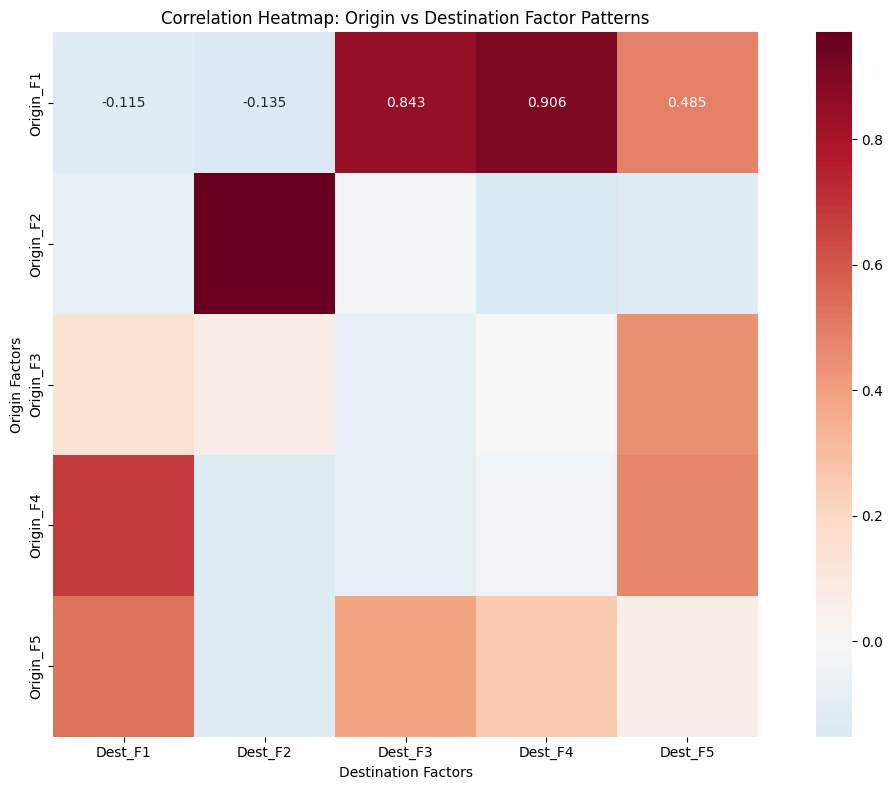

Origin factor shape: (45, 5)
Destination factor shape: (45, 5)
Correlation matrix shape: (5, 5)
Mean correlation: 0.206
Max correlation: 0.971
Min correlation: -0.152


In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import json

# Load the tensor decomposition factors
decomposition_path = str(PROJECT_ROOT) + "/data/results/decompositions/CP/final/peak hours normalized/utrecht/odt_no_same_od_no_rare_od_fixed_thresh_normalizedPeaks/odt_utrecht_hourly_weekday/run_20250610_001409/rank_5/odt_processed_utrecht_hourly_weekday_factors.npz"

factors_data = np.load(decomposition_path, allow_pickle=True)
origin_factor = factors_data['factors'][0]  # Shape: (n_origins, rank)
# Shape: (n_destinations, rank)
destination_factor = factors_data['factors'][1]

# Load the index mappings to get postal code labels
run_dir = Path(decomposition_path).parent.parent
run_summary_path = run_dir / "run_summary.json"

with open(run_summary_path, 'r') as f:
    run_summary = json.load(f)

tensor_file_path = run_summary["tensor_info"]["file"]
tensor_dir = Path(tensor_file_path).parent
granularity = Path(decomposition_path).name.split('_')[-2]  # "weekday"

index_mapping_path = tensor_dir / \
    f"index_mappings_utrecht_{granularity}_hourly.json"
with open(index_mapping_path, 'r') as f:
    index_mappings = json.load(f)

idx_to_origins = index_mappings['idx_to_origins']
idx_to_destinations = index_mappings['idx_to_destinations']

# Create DataFrames with postal codes as labels
origin_df = pd.DataFrame(origin_factor,
                         index=[idx_to_origins[str(i)]
                                for i in range(len(origin_factor))],
                         columns=[f'Factor_{i+1}' for i in range(origin_factor.shape[1])])

destination_df = pd.DataFrame(destination_factor,
                              index=[idx_to_destinations[str(i)] for i in range(
                                  len(destination_factor))],
                              columns=[f'Factor_{i+1}' for i in range(destination_factor.shape[1])])

# Calculate correlation matrix between origin and destination factors
# Each row in origin_df corresponds to a postal code, each column is a factor
# We want to correlate the factor patterns (columns) between origins and destinations
corr_matrix = np.zeros((origin_factor.shape[1], destination_factor.shape[1]))

for i in range(origin_factor.shape[1]):  # For each origin factor
    for j in range(destination_factor.shape[1]):  # For each destination factor
        # Calculate correlation between the i-th origin factor and j-th destination factor
        # across all postal codes
        corr = np.corrcoef(origin_factor[:, i], destination_factor[:, j])[0, 1]
        corr_matrix[i, j] = corr

# Create the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix,
            xticklabels=[
                f'Dest_F{i+1}' for i in range(destination_factor.shape[1])],
            yticklabels=[
                f'Origin_F{i+1}' for i in range(origin_factor.shape[1])],
            annot=True,
            cmap='RdBu_r',
            center=0,
            fmt='.3f',
            square=True)

plt.title('Correlation Heatmap: Origin vs Destination Factor Patterns')
plt.xlabel('Destination Factors')
plt.ylabel('Origin Factors')
plt.tight_layout()
plt.show()

# Print summary statistics
print(f"Origin factor shape: {origin_factor.shape}")
print(f"Destination factor shape: {destination_factor.shape}")
print(f"Correlation matrix shape: {corr_matrix.shape}")
print(f"Mean correlation: {corr_matrix.mean():.3f}")
print(f"Max correlation: {corr_matrix.max():.3f}")
print(f"Min correlation: {corr_matrix.min():.3f}")

## Tucker


### Generic Setup


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import json

# Load the tensor decomposition factors
# decomposition_weekday_path =  str(PROJECT_ROOT) + "/data/results/decompositions/tucker/hourly_analysis/odt_utrecht_hourly_weekday/MU/run_20250610_123349/rank_5_5_4/odt_utrecht_hourly_weekday_factors.npz"

# decomposition_weekend_path =  str(PROJECT_ROOT) + "/data/results/decompositions/tucker/hourly_analysis/odt_utrecht_hourly_weekend/MU/run_20250610_123349/rank_4_4_5/odt_utrecht_hourly_weekend_factors.npz"

# Load the tensor decomposition factors
decomposition_weekday_path = '/Users/peterfalterbaum/Documents/Nova/thesis local/implementation/rocket riding/data/results/decompositions/tucker/hourly_analysis/odt_rotterdam_hourly_weekday/MU/run_20250610_123349/rank_4_4_3/odt_rotterdam_hourly_weekday_factors.npz'

decomposition_weekend_path = str(
    PROJECT_ROOT) + "/data/results/decompositions/tucker/hourly_analysis/odt_rotterdam_hourly_weekend/MU/run_20250610_123349/rank_4_4_3/odt_rotterdam_hourly_weekend_factors.npz"


def load_factors(decomposition_path):
    factors_data = np.load(decomposition_path, allow_pickle=True)
    # Shape: (n_origins, rank_origin)
    origin_factor = factors_data['factors'][0]
    # Shape: (n_destinations, rank_destination)
    destination_factor = factors_data['factors'][1]
    # Shape: (n_time_periods, rank_time)
    time_factor = factors_data['factors'][2]
    # Shape: (rank_origin, rank_destination, rank_time)
    core_tensor = factors_data['core']
    return origin_factor, destination_factor, time_factor, core_tensor


origin_factor_weekday, destination_factor_weekday, time_factor_weekday, core_tensor_weekday = load_factors(
    decomposition_weekday_path)

origin_factor_weekend, destination_factor_weekend, time_factor_weekend, core_tensor_weekend = load_factors(
    decomposition_weekend_path)

### Approach, based on Sun & Axhausen


/var/folders/bj/r88z9c613s17r0cbp2t30cmm0000gn/T/ipykernel_7002/501255391.py:139: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig.subplots_adjust(top=0.88)


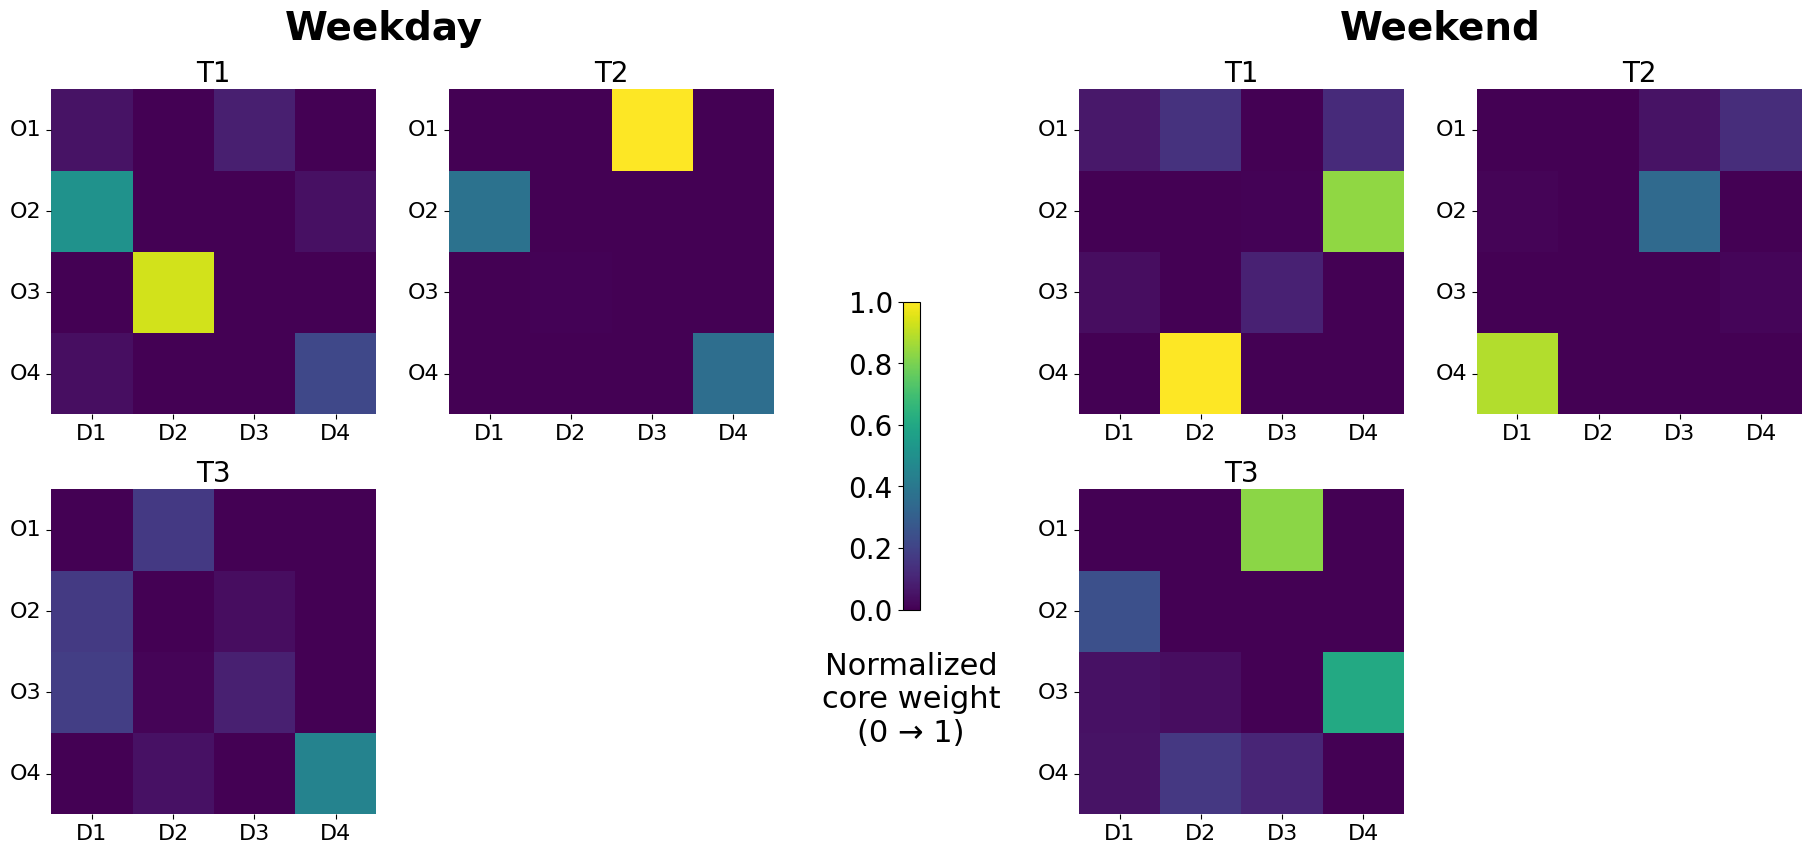

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
from matplotlib.gridspec import GridSpec

# — assume core_tensor_weekday and core_tensor_weekend are already defined —

# 1) Min–max normalize each core
core_wd = core_tensor_weekday / core_tensor_weekday.max()
core_we = core_tensor_weekend / core_tensor_weekend.max()

# 2) Dimensions & labels
R_o_w, R_d_w, R_t_w = core_wd.shape
R_o_e, R_d_e, R_t_e = core_we.shape

orig_w = [f"O{i+1}" for i in range(R_o_w)]
dest_w = [f"D{j+1}" for j in range(R_d_w)]
orig_e = [f"O{i+1}" for i in range(R_o_e)]
dest_e = [f"D{j+1}" for j in range(R_d_e)]

# 3) Compute grid layout for each block
ncols_w = math.ceil(math.sqrt(R_t_w))
nrows_w = math.ceil(R_t_w / ncols_w)
ncols_e = math.ceil(math.sqrt(R_t_e))
nrows_e = math.ceil(R_t_e / ncols_e)
nrows = max(nrows_w, nrows_e)

# 4) Define width ratios (weekday | spacer | cbar | spacer | weekend-with-gaps)
w_w = 0.7    # weekday block width per column
w_gap_w = 0.05  # gap between weekday columns
w_s1 = 0.2   # spacer before colorbar
w_c = 0.05   # colorbar width
w_s2 = 0.3   # spacer after colorbar
w_e = 0.7    # weekend block width per column
w_gap_e = 0.05    # extra gap *between* weekend columns

# build the weekday-with-gaps part
weekday_ratios = []
for i in range(ncols_w):
    weekday_ratios.append(w_w)
    if i < ncols_w - 1:
        weekday_ratios.append(w_gap_w)

# build the weekend-with-gaps part:
weekend_ratios = []
for i in range(ncols_e):
    weekend_ratios.append(w_e)
    if i < ncols_e - 1:
        weekend_ratios.append(w_gap_e)

# now concatenate everything
width_ratios = (
    weekday_ratios
    + [w_s1, w_c, w_s2]
    + weekend_ratios
)
total_cols = len(width_ratios)  # used when building GridSpec

# 5) Rebuild the figure & GridSpec
fig = plt.figure(
    figsize=(3*(ncols_w + ncols_e) + 6, 4*nrows),
    constrained_layout=True
)
gs = GridSpec(
    nrows=nrows,
    ncols=total_cols,
    width_ratios=width_ratios,
    figure=fig
)

# 6) Plot weekday—but remember each real column is now two indices apart
for k in range(R_t_w):
    r, c = divmod(k, ncols_w)
    col_idx = c * 2        # skip one extra "gap" slot after each
    ax = fig.add_subplot(gs[r, col_idx])
    sns.heatmap(
        core_wd[:, :, k], ax=ax, vmin=0, vmax=1, cmap="viridis",
        cbar=False, xticklabels=dest_w, yticklabels=orig_w, square=True
    )
    ax.set_title(f"T{k+1}", fontsize=20)
    ax.tick_params(labelsize=16)
    # Make origin labels upright
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
# turn off any extra weekday axes
for idx in range(R_t_w, nrows_w * ncols_w):
    r, c = divmod(idx, ncols_w)
    col_idx = c * 2
    fig.add_subplot(gs[r, col_idx]).axis("off")

# 7) Plot weekend—but remember each real column is now two indices apart
offset = len(weekday_ratios) + 3  # weekday columns + [w_s1, w_c, w_s2]
for k in range(R_t_e):
    r, c = divmod(k, ncols_e)
    col_idx = offset + (c * 2)        # skip one extra "gap" slot after each
    ax = fig.add_subplot(gs[r, col_idx])
    sns.heatmap(
        core_we[:, :, k], ax=ax, vmin=0, vmax=1, cmap="viridis",
        cbar=False, xticklabels=dest_e, yticklabels=orig_e, square=True
    )
    ax.set_title(f"T{k+1}", fontsize=20)
    ax.tick_params(labelsize=16)
    # Make origin labels upright
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
# turn off any extra weekend axes
for idx in range(R_t_e, nrows_e * ncols_e):
    r, c = divmod(idx, ncols_e)
    col_idx = offset + (c * 2)
    fig.add_subplot(gs[r, col_idx]).axis("off")


# 8) Shared colorbar (manually shrink height by 50%)
mappable = fig.axes[0].collections[0]
cax = fig.add_subplot(gs[:, len(weekday_ratios)+1])
cb = fig.colorbar(
    mappable,
    cax=cax,
    orientation='vertical'
)

# Manually grab its original position and shrink it
pos = cax.get_position()          # Bbox(x0, y0, width, height)
new_height = pos.height * 0.5      # half the height
new_y0 = pos.y0 + (pos.height - new_height) / 2  # center it vertically

cax.set_position([pos.x0, new_y0, pos.width, new_height])

# relabel and style as before
cax.set_xlabel("Normalized\ncore weight\n(0 → 1)",
               labelpad=30, fontsize=22)  # increased from 18
cax.yaxis.set_ticks_position('left')
cax.tick_params(labelsize=20)  # increased from 16


# … everything up through step 8 stays the same …

# 9) Pull down the whole grid so there's extra space at the top
# shrink plotting region to 88% of the figure height
fig.subplots_adjust(top=0.88)

# 10) Compute header x‐positions (unchanged)
left_block_width = sum(width_ratios[:len(weekday_ratios)])
left_center = (left_block_width/2)/sum(width_ratios)
start_weekend = len(weekday_ratios) + 3
right_block_width = sum(width_ratios[start_weekend:start_weekend+ncols_e])
right_center = (sum(width_ratios[:start_weekend]
                    ) + right_block_width)/sum(width_ratios)


# 11) Add headers *lower* than before
header_y = 1.005   # down from 0.95 to 0.93 in figure‐coords
fig.text(left_center,  header_y, "Weekday",
         fontsize=28, fontweight='bold', ha='center', va='bottom')  # increased from 24
fig.text(right_center, header_y, "Weekend",
         fontsize=28, fontweight='bold', ha='center', va='bottom')  # increased from 24

plt.show()